In [1]:
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity, plot_2dsim
from tqdm import tqdm
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import colorbar
from scipy.interpolate import interp2d, Rbf
import matplotlib

In [2]:
X, y = generate_gaussian_parity(1000)
X_ood1, y_ood1 = generate_gaussian_parity(1000, angle_params=np.pi/6)
X_ood2, y_ood2 = generate_gaussian_parity(1000, angle_params=np.pi/4)
X_ood3, y_ood3 = generate_gaussian_parity(1000, angle_params=np.pi/2)

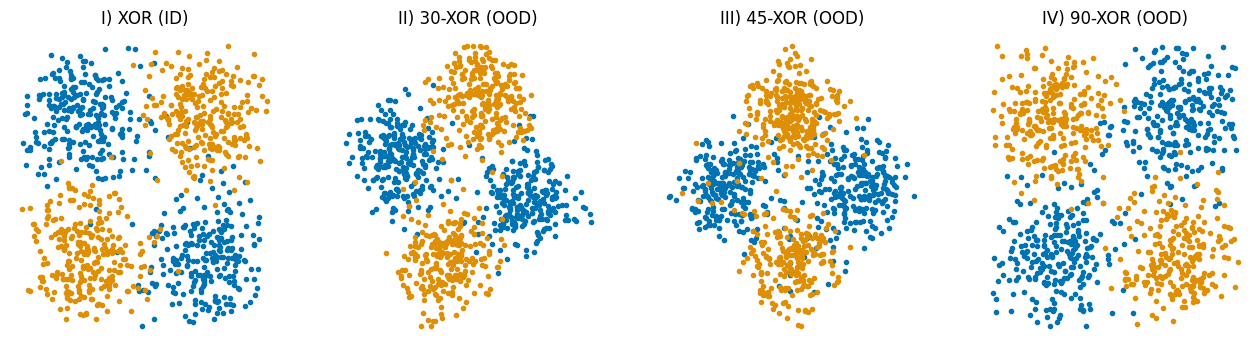

In [3]:
fig, ax = plt.subplots(1,4,figsize=(16,4))

plot_2dsim(X,y, ax=ax[0])
plot_2dsim(X_ood1,y_ood1, ax=ax[1])
plot_2dsim(X_ood2,y_ood3, ax=ax[2])
plot_2dsim(X_ood3,y_ood3, ax=ax[3])

for ii in range(4):
    right_side = ax[ii].spines["right"]
    right_side.set_visible(False)
    top_side = ax[ii].spines["top"]
    top_side.set_visible(False)
    left_side = ax[ii].spines["left"]
    left_side.set_visible(False)
    bottom_side = ax[ii].spines["bottom"]
    bottom_side.set_visible(False)
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])



ax[0].set_title('I) XOR (ID)')
ax[1].set_title(r'II) 30-XOR (OOD)')
ax[2].set_title(r'III) 45-XOR (OOD)')
ax[3].set_title(r'IV) 90-XOR (OOD)')

plt.savefig('simulation.pdf')

In [198]:
n_estimators = 100
n_seeds = 10
#splitting_criteria = ['gini', 'entropy', 'log_loss']
depth = np.arange(1,32,1)
n_criteria = len(depth)
n_train_id = 1000
n_test_id = 1000
n_eval_ood = 1000
n_test_ood = 1000
angles = [0, np.pi/6, np.pi/4, np.pi/2]

In [199]:
def experiment(angle, n_components, stress=False, n_estimators=500):
    rf_models = [[] for _ in range(n_criteria)]

    np.random.seed(10)
    x_train_id, y_train_id = generate_gaussian_parity(n_train_id)
    x_test_id, y_test_id = generate_gaussian_parity(n_test_id)
    
    x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=angle)
    x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=angle)
    
    for i in range(n_criteria):
        for j in range(n_seeds):
            model = rf(n_estimators=n_estimators, max_depth=depth[i], random_state=(i+1)*(j+1))
            model.fit(x_train_id, y_train_id)
            rf_models[i].append(model)

    ##########################################################
    l_id = np.zeros((n_criteria, n_seeds), dtype=float)
    l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
    proba = []
    
    for i in (range(n_criteria)):
        for j in range(n_seeds):
            proba.append(
                rf_models[i][j].predict_proba(x_eval_ood)
            )
            y_pred_id = rf_models[i][j].predict(x_test_id)
            y_pred_ood = rf_models[i][j].predict(x_test_ood)
            l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
            l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)

    ########################################################
    D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

    for ii in range(n_seeds*n_criteria):
        for jj in range(ii+1, n_seeds*n_criteria):
            D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
            D[jj,ii] = D[ii,jj]

    #######################################################

    embedding = MDS(n_components=n_components, dissimilarity='precomputed', random_state=101)
    X_transformed = embedding.fit_transform(D)

    if stress:
        return X_transformed, l_id, l_ood, embedding.stress_
    else:
        return X_transformed, l_id, l_ood

In [200]:
X_transformed, l_id, l_ood = [], [], []
for angle in tqdm(angles):
    X_, l_id_, l_ood_ = experiment(angle, 2, n_estimators=n_estimators)
    X_transformed.append(X_)
    l_id.append(l_id_)
    l_ood.append(l_ood_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:40<00:00, 25.09s/it]


In [219]:
def plot_embeddings(X_transformed, l_id, l_ood, angle, ax, l_i_min, l_i_max, l_o_min, l_o_max):
    cmap = cm.coolwarm
    
    for ii in range(l_id.shape[0]):
        ax.scatter(X_transformed[ii*10:(ii+1)*10,0], X_transformed[ii*10:(ii+1)*10,1], c=cmap(((l_id[ii,:]-l_i_min)/(l_i_max-l_i_min))), s=100*((l_ood[ii,:]-l_o_min)/(l_o_max-l_o_min)))
    
    #ax.set_zlabel('l_ood')
    #ax.set_xlabel('X1')
    #ax.set_ylabel('X2')
    #ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    #ax.set_xticks([-1,0,1])
    ax.set_xticks([-15, -10, -5, 0, 4])
    ax.set_yticks([0,5,10,15])
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)


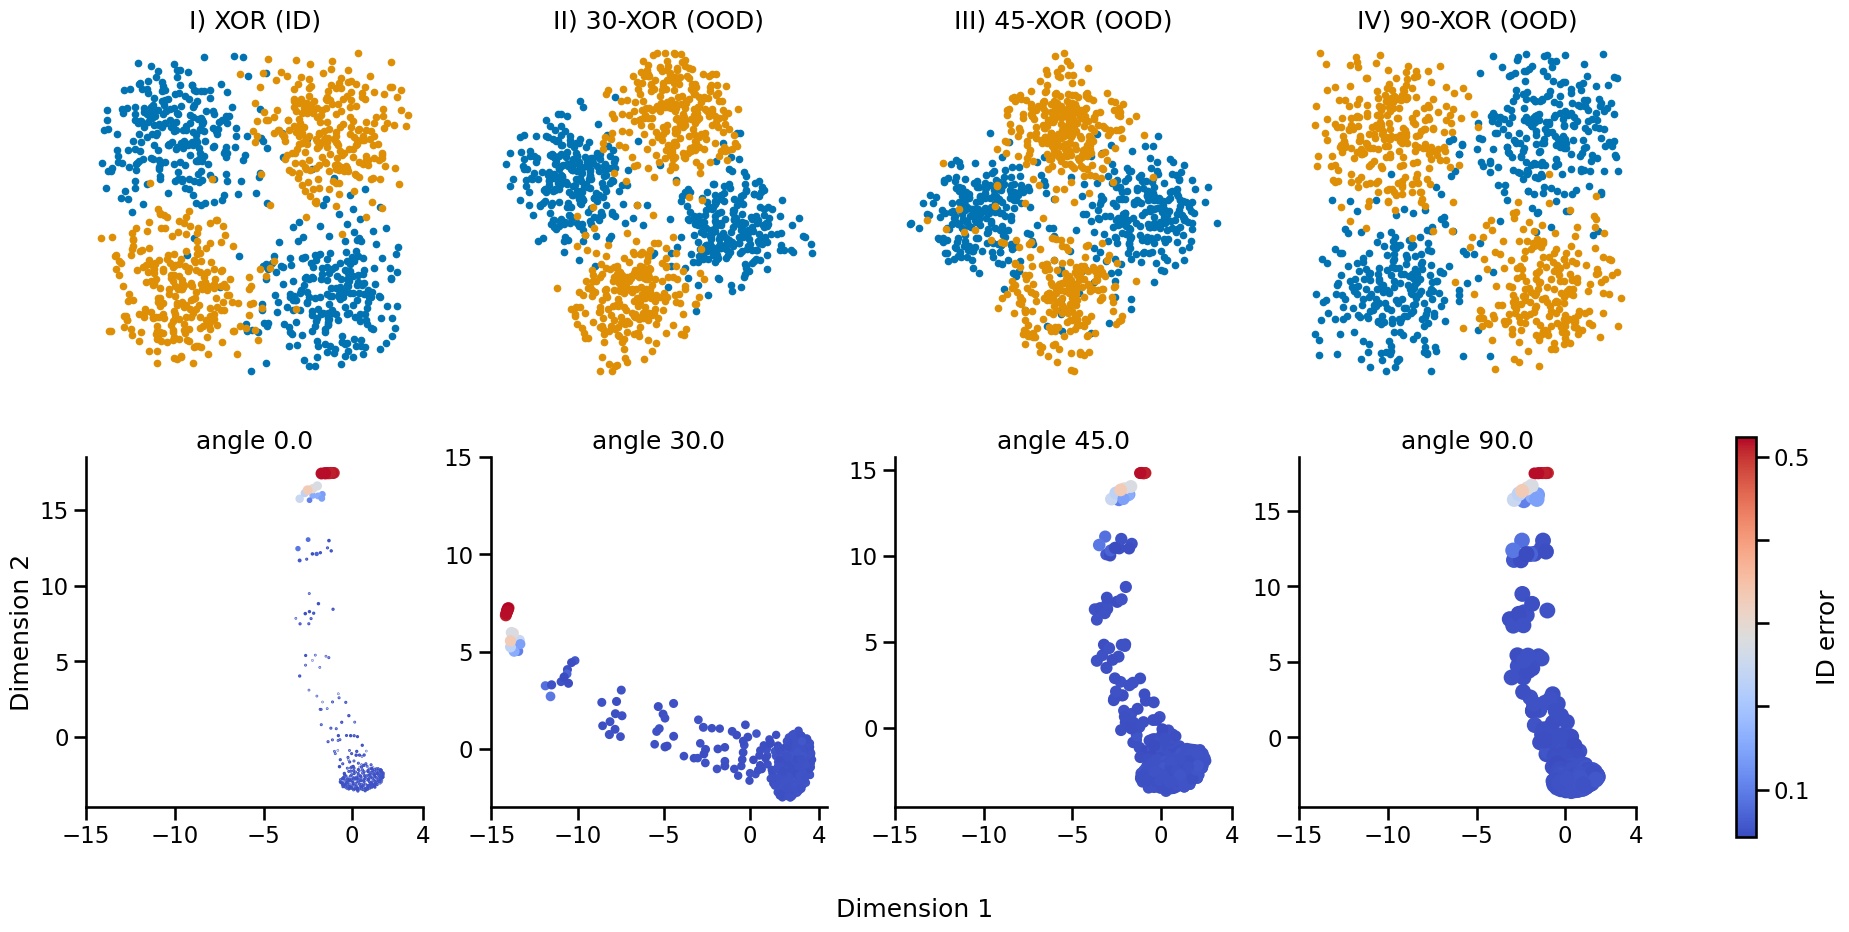

In [223]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sns.set_context('talk')

plot_2dsim(X,y, ax=ax[0][0])
plot_2dsim(X_ood1,y_ood1, ax=ax[0][1])
plot_2dsim(X_ood2,y_ood3, ax=ax[0][2])
plot_2dsim(X_ood3,y_ood3, ax=ax[0][3])

for ii in range(4):
    right_side = ax[0][ii].spines["right"]
    right_side.set_visible(False)
    top_side = ax[0][ii].spines["top"]
    top_side.set_visible(False)
    left_side = ax[0][ii].spines["left"]
    left_side.set_visible(False)
    bottom_side = ax[0][ii].spines["bottom"]
    bottom_side.set_visible(False)
    ax[0][ii].set_xticks([])
    ax[0][ii].set_yticks([])



ax[0][0].set_title('I) XOR (ID)')
ax[0][1].set_title(r'II) 30-XOR (OOD)')
ax[0][2].set_title(r'III) 45-XOR (OOD)')
ax[0][3].set_title(r'IV) 90-XOR (OOD)')

l_i_min = np.min(l_id)
l_i_max = np.max(l_id)
l_o_min = np.min(l_ood)
l_o_max = np.max(l_ood)

for ii, angle in enumerate(angles):
    plot_embeddings(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax[1][ii], l_i_min, l_i_max, l_o_min, l_o_max)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=l_i_min, vmax=l_i_max), cmap=cm.coolwarm)
cbaxes = fig.add_axes([.95, 0.08, 0.01, 0.4])
cbar = fig.colorbar(sm, cbaxes, label='ID error')
cbar.ax.set_yticklabels(['', str(0.1), '', '', '',  str(np.round(l_i_max,1))])

ax[1][0].set_ylabel('Dimension 2')
fig.text(0.5, 0, 'Dimension 1')
plt.savefig('embeddings.pdf', bbox_inches='tight')

In [208]:
import pickle

summary = (X_transformed, l_id, l_ood)

with open('result.pickle','wb') as f:
    pickle.dump(summary, f)

In [209]:
import pickle
with open('result.pickle','rb') as f:
    (X_transformed, l_id, l_ood) = pickle.load(f)


In [164]:
np.min(l_id)

0.04400000000000004

In [165]:
np.max(l_id)

0.524

In [170]:
l_i_max

0.524